In [1]:
import json
# import ast

import pandas as pd
from pandarallel import pandarallel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import torch
import os
from tqdm import tqdm
import pickle
import warnings
from collections import Counter
from transformers import AutoTokenizer
from Levenshtein import distance as lev_distance

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [58]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last one

In [45]:
import sqlite3


def read_from_db(query):
    conn = sqlite3.connect("../data/processed/recipies.db")
    df = pd.read_sql(query, conn)
    return df


read_from_db(
    """
    select  *
    from    products
    """
)

id            product    qnt  occurrence_in_recipies
0     0     —Å–æ–ª—å               78056  0.532511              
1     1     —è–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ       58219  0.397180              
2     2     –º—É–∫–∞ –ø—à–µ–Ω–∏—á–Ω–∞—è     50689  0.345809              
3     3     —Å–∞—Ö–∞—Ä              50580  0.345065              
4     4     –ª—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π       40855  0.278720              
...  ..              ...         ...       ...              
1093  1093  —Ç–≤–æ—Ä–æ–≥ –∂–∏—Ä–Ω—ã–π      1      0.000007              
1094  1094  —Å–º–µ—Ç–∞–Ω–∫–∞           1      0.000007              
1095  1095  –∂–µ–ª—Ç–∫–∏ —è–∏—á–Ω—ã–µ      1      0.000007              
1096  1096  –∏–∑—é–º –±–µ–∑ –∫–æ—Å—Ç–æ—á–µ–∫  1      0.000007              
1097  1097  –∞—Å–∞—Ñ–µ—Ç–∏–¥–∞          1      0.000007              

[1098 rows x 4 columns]

In [39]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")

In [2]:
data = pd.read_csv("../data/raw/povarenok_recipes_2021_06_16.csv").drop(columns=['url']).dropna(subset=['ingredients'])
data

name  \
0       –ì—É—Å—Ç–æ–π –º–æ–ª–æ—á–Ω–æ-–∫–ª—É–±–Ω–∏—á–Ω—ã–π –∫–æ–∫—Ç–µ–π–ª—å              
1       –†—É–ª–µ—Ç–∏–∫–∏                                        
2       –°–∞–ª–∞—Ç "–ë–∞–∫–ª–∞–∂–∞–Ω—á–∏–∫"                             
3       –ö—É—Ä–∏–Ω—ã–µ –∫–æ—Ç–ª–µ—Ç—ã —Å –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω—ã–º –ø—é—Ä–µ –≤ –¥—É—Ö–æ–≤–∫–µ   
4       –†–µ—Ü–µ–ø—Ç –≤–∏—à–Ω–µ–≤–æ–π –Ω–∞–ª–∏–≤–∫–∏                         
...                         ...                         
146577  –£–∫—Ä–∞—à–µ–Ω–∏–µ –¥–ª—è –±–ª—é–¥ "–°–Ω–µ–∂–∏–Ω–∫–∞"                   
146578  –ì—Ä–µ—á–µ—Å–∫–∏–π —Ä–∏—Å–æ–≤—ã–π –ø–∏—Ä–æ–≥ —Å —Ñ–∞—Ä—à–µ–º                
146579  –°–æ—É—Å –Ω–∞ –≥—Ä—É–∑–¥—è—Ö —Å —Ö—Ä–µ–Ω–æ–º                        
146580  –ü–µ—á–µ–Ω—å–µ —Å–æ —Å–ª–∏–≤–æ—á–Ω—ã–º —Å—ã—Ä–æ–º                      
146581  –ü–∏—Ä–æ–≥ "–í–µ—Å–µ–Ω–Ω–∏–π" —Å —è–±–ª–æ–∫–∞–º–∏ –∏ –∞–ø–µ–ª—å—Å–∏–Ω–∞–º–∏       

                                                                                                                                                                                                                                                                                                                                ingredients  
0       {'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}                                                                                                                                                                                                                                                                           
1       {'–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': None, '–ß–µ—Å–Ω–æ–∫': None, '–Ø–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ': None, '–ì—Ä–µ–π–ø—Ñ—Ä—É—Ç': None, '–õ—É–∫ –∑–µ–ª–µ–Ω—ã–π': None, '–õ–∏—Å—Ç—å—è —Å–∞–ª–∞—Ç–∞': None, '–ú–∞–π–æ–Ω–µ–∑': None}                                                                                                                                                                                          
2       {'–ë–∞–∫–ª–∞–∂–∞–Ω': '3 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '2 —à—Ç', '–ü–æ–º–∏–¥–æ—Ä': '2 —à—Ç', '–ß–µ—Å–Ω–æ–∫': '1 –∑—É–±.', '–°–æ–ª—å': None, '–ú–∞–π–æ–Ω–µ–∑': None, '–ü–µ—Ä–µ—Ü —á–µ—Ä–Ω—ã–π': None}                                                                                                                                                                                             
3       {'–§–∞—Ä—à –∫—É—Ä–∏–Ω—ã–π': '800 –≥', '–ü—é—Ä–µ –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω–æ–µ': '1 –∫–≥', '–ñ–µ–ª—Ç–æ–∫ —è–∏—á–Ω—ã–π': '1 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '1 —à—Ç', '–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': '150 –≥', '–ú–æ–ª–æ–∫–æ': '50 –º–ª', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '30 –≥', '–ó–µ–ª–µ–Ω—å': '0,5 –ø—É—á.', '–ü—Ä–∏–ø—Ä–∞–≤–∞': '1,5 —á. –ª.', '–ú–∞—Å–ª–æ —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–µ': '5 —Å—Ç. –ª.'}                                                                       
4       {'–í–∏—à–Ω—è': '1 –∫–≥', '–í–æ–¥–∫–∞': '1 –ª', '–°–∞—Ö–∞—Ä': '300 –≥', '–ö–æ—Å—Ç–∏': '50 –≥', '–ö–æ—Ä–∏—Ü–∞': '8 –≥', '–ì–≤–æ–∑–¥–∏–∫–∞': '3 —à—Ç'}                                                                                                                                                                                                                            
...                                                                                                           ...                                                                                                                                                                                                                            
146577  {'–ö–∞–ø—É—Å—Ç–∞ –∫—Ä–∞—Å–Ω–æ–∫–æ—á–∞–Ω–Ω–∞—è': None, '–ö–∞–ø—É—Å—Ç–∞ –±–µ–ª–æ–∫–æ—á–∞–Ω–Ω–∞—è': None}                                                                                                                                                                                                                                                                       
146578  {'–§–∞—Ä—à –º—è—Å–Ω–æ–π': '400 –≥', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '2 —Å—Ç.

# Get Embeddings

Bert Encoders comparison

In [3]:
print("'ai-forever/sbert_large_nlu_ru' Tokenizer: ",
      AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru").tokenize(["–º–æ–ª–æ–∫–æ", "—Å–∞—Ö–∞—Ä"]))
print("'bert-base-multilingual-uncased' Tokenizer: ",
      AutoTokenizer.from_pretrained("bert-base-multilingual-uncased").tokenize(["–º–æ–ª–æ–∫–æ", "—Å–∞—Ö–∞—Ä"]))

'ai-forever/sbert_large_nlu_ru' Tokenizer:  ['–º–æ–ª–æ–∫–æ', '—Å–∞—Ö–∞—Ä']
'bert-base-multilingual-uncased' Tokenizer:  ['–º–æ', '##–ª–æ–∫', '##–æ', '—Å–∞', '##—Ö–∞', '##—Ä']


As we can see above, Tokenizer "bert-base-multilingual-uncased" splits Russian words the strange way (checked with the tokenize() method), so we will go with "ai-forever/sbert_large_nlu_ru" that yields all in all satisfactory results

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
tokenizer

BertTokenizerFast(name_or_path='ai-forever/sbert_large_nlu_ru', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [5]:
tokenizer(['–º–æ–ª–æ–∫–æ', '–∫–ª—É–±–Ω–∏–∫–∞', '—Å–∞—Ö–∞—Ä'])

{'input_ids': [[101, 17066, 102], [101, 4378, 1032, 102], [101, 14500, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1], [1, 1, 1]]}

In [6]:
test_json = data.iloc[0, 1]


def json_to_norm_list(input_json):
    import ast
    norm_json = ast.literal_eval(input_json)  # json normalization
    return [el.lower() for el in norm_json]


json_to_norm_list(test_json)

['–º–æ–ª–æ–∫–æ', '–∫–ª—É–±–Ω–∏–∫–∞', '—Å–∞—Ö–∞—Ä']

In [7]:
def make_embeddings_list(ingredients_list: list):
    return [tokenizer(el).input_ids for el in ingredients_list]


make_embeddings_list(['–º–æ–ª–æ–∫–æ', '–∫–ª—É–±–Ω–∏–∫–∞', '—Å–∞—Ö–∞—Ä'])

[[101, 17066, 102], [101, 4378, 1032, 102], [101, 14500, 102]]

# Get common ingredients

In [8]:
# def get_common_ingredients():
#     pass

In [36]:
ingredients_all = data.ingredients.parallel_apply(lambda x: json_to_norm_list(x))

In [33]:
def flatter_lists(l):
    return [item for sublist in l for item in sublist]


products_freq = pd.DataFrame.from_records(Counter(flatter_lists(ingredients_all)).most_common(),
                                          columns=['product', 'qnt'])
products_freq['occurrence_in_recipies'] = products_freq['qnt'] / len(data)
products_freq

product    qnt  occurrence_in_recipies
0     —Å–æ–ª—å               78056  0.532511              
1     —è–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ       58219  0.397180              
2     –º—É–∫–∞ –ø—à–µ–Ω–∏—á–Ω–∞—è     50689  0.345809              
3     —Å–∞—Ö–∞—Ä              50580  0.345065              
4     –ª—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π       40855  0.278720              
...            ...         ...       ...              
1093  —Ç–≤–æ—Ä–æ–≥ –∂–∏—Ä–Ω—ã–π      1      0.000007              
1094  —Å–º–µ—Ç–∞–Ω–∫–∞           1      0.000007              
1095  –∂–µ–ª—Ç–∫–∏ —è–∏—á–Ω—ã–µ      1      0.000007              
1096  –∏–∑—é–º –±–µ–∑ –∫–æ—Å—Ç–æ—á–µ–∫  1      0.000007              
1097  –∞—Å–∞—Ñ–µ—Ç–∏–¥–∞          1      0.000007              

[1098 rows x 3 columns]

In [11]:
products_freq_plot = (
    products_freq
    .sort_values(by='occurrence_in_recipies')
    .reset_index(drop=True)
    .assign(accumulative_probability=lambda df_: (df_.index + 1) * (1 / len(df_)))
    .groupby('occurrence_in_recipies', as_index=False)
    .accumulative_probability
    .max()
)
products_freq_plot

occurrence_in_recipies  accumulative_probability
0    0.000007                0.113843                
1    0.000014                0.140255                
2    0.000020                0.161202                
3    0.000027                0.169399                
4    0.000034                0.186703                
..        ...                     ...                
514  0.278720                0.996357                
515  0.345065                0.997268                
516  0.345809                0.998179                
517  0.397180                0.999089                
518  0.532511                1.000000                

[519 rows x 2 columns]

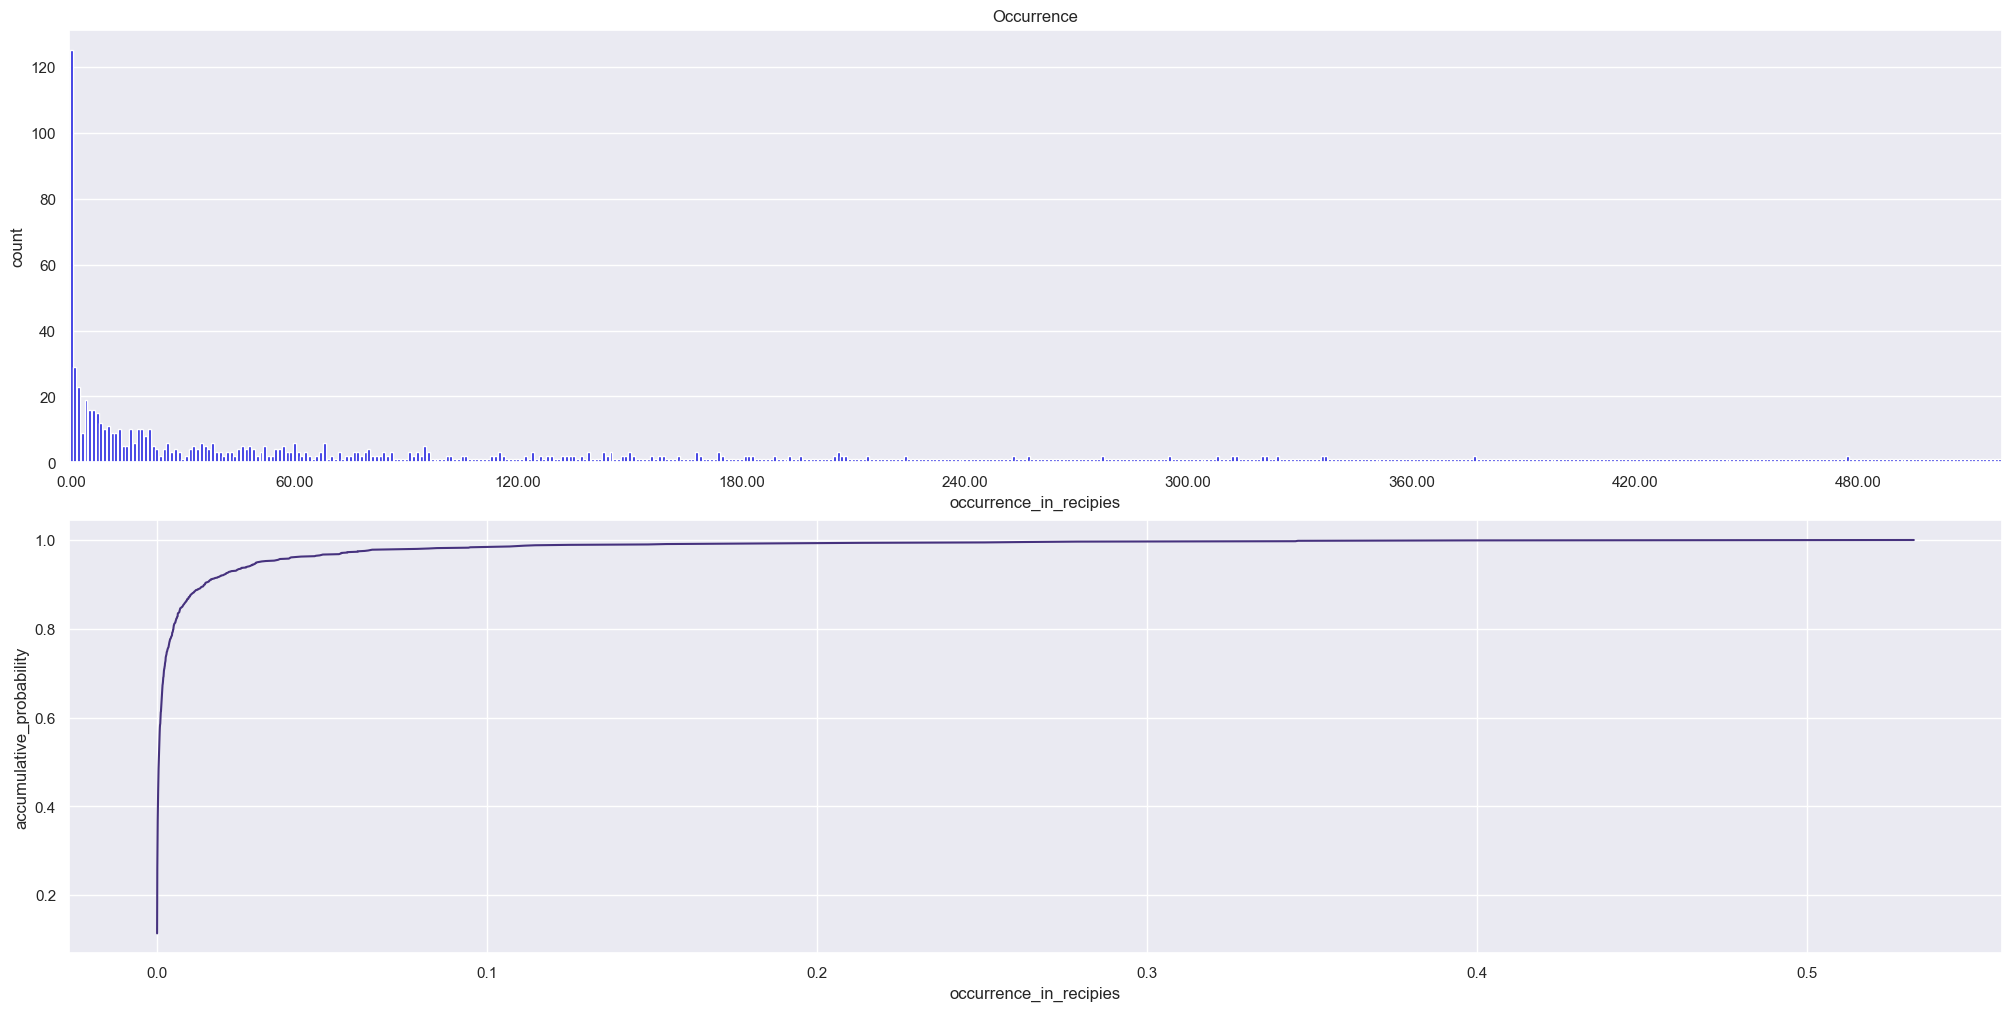

In [12]:
fig = plt.figure(layout="constrained")
ax = fig.subplot_mosaic("""
    AA
    BB
""")
sns.countplot(data=products_freq, x='occurrence_in_recipies', color='blue', ax=ax['A']).set_title('Occurrence')
ax['A'].xaxis.set_major_locator(ticker.MaxNLocator(10))
ax['A'].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
sns.lineplot(products_freq_plot, x='occurrence_in_recipies', y='accumulative_probability', ax=ax['B'])
plt.show()

Threshold 1% seems reasonable to recognize element as widely used and thus available on the average kitchen

In [13]:
common_ingredients = products_freq.query("occurrence_in_recipies >= 0.01")['product'].to_list()

# Search matching recipies

In [14]:
input = ['–∫–ª—É–±–Ω–∏–∫–∞', '–ø–æ–º–∏–¥–æ—Ä', '–≥—Ä–µ–π–ø—Ñ—Ä—É—Ç']

In [15]:
make_embeddings_list(input)

[[101, 4378, 1032, 102],
 [101, 79087, 102],
 [101, 3001, 378, 58057, 19961, 102]]

In [16]:
(np.array(tokenizer('–∫–ª—É–±–Ω–∏–∫–∞, –ø–æ–º–∏–¥–æ—Ä, –≥—Ä–µ–π–ø—Ñ—Ä—É—Ç').input_ids)).dot(
    np.array(tokenizer('–∫–ª—É–±–Ω–∏–∫–∞, –ø–æ–º–∏–¥–æ—Ä, –≥—Ä–µ–π–ø—Ñ—Ä—É—Ç').input_ids).T).ravel()

array([10053241019])

In [17]:
tokenizer('–∫–ª—É–±–Ω–∏–∫–∞, –ø–æ–º–∏–¥–æ—Ä, –≥—Ä–µ–π–ø—Ñ—Ä—É—Ç').input_ids

[101, 4378, 1032, 121, 79087, 121, 3001, 378, 58057, 19961, 102]

In [40]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
emb1 = model.encode('–∫–ª—É–±–Ω–∏–∫–∞, –ø–æ–º–∏–¥–æ—Ä, –≥—Ä–µ–π–ø—Ñ—Ä—É—Ç', convert_to_tensor=True)
emb2 = model.encode('–∫–ª—É–±–Ω–∏as', convert_to_tensor=True)
emb1.dot(emb2.T)

tensor(0.7211, device='mps:0')

In [19]:
emb2.size()

torch.Size([384])

let's try pooling

In [20]:
# token max length is
max_length = 0
for word in products_freq['product'].to_list():
    max_length = max(max_length, len(word))
    if len(word) == max_length:
        lengthy_word = word
max_length

35

In [21]:
db_products = products_freq.reset_index().rename(columns={'index': 'id'})
db_products

id            product    qnt  occurrence_in_recipies
0     0     —Å–æ–ª—å               78056  0.532511              
1     1     —è–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ       58219  0.397180              
2     2     –º—É–∫–∞ –ø—à–µ–Ω–∏—á–Ω–∞—è     50689  0.345809              
3     3     —Å–∞—Ö–∞—Ä              50580  0.345065              
4     4     –ª—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π       40855  0.278720              
...  ..              ...         ...       ...              
1093  1093  —Ç–≤–æ—Ä–æ–≥ –∂–∏—Ä–Ω—ã–π      1      0.000007              
1094  1094  —Å–º–µ—Ç–∞–Ω–∫–∞           1      0.000007              
1095  1095  –∂–µ–ª—Ç–∫–∏ —è–∏—á–Ω—ã–µ      1      0.000007              
1096  1096  –∏–∑—é–º –±–µ–∑ –∫–æ—Å—Ç–æ—á–µ–∫  1      0.000007              
1097  1097  –∞—Å–∞—Ñ–µ—Ç–∏–¥–∞          1      0.000007              

[1098 rows x 4 columns]

In [56]:
l = '–ú–æ–ª–æ–∫–æ, –ö–ª—É–±–Ω–∏–∫–∞ –°–∞—Ö–∞—Ä'
import re

re.split('; |, |\;|\n|\\s', l)

['–ú–æ–ª–æ–∫–æ', '–ö–ª—É–±–Ω–∏–∫–∞', '–°–∞—Ö–∞—Ä']

In [46]:
%%time
logging = []
matches = []
# is it cooler to weight lev distance on the distance of "mistapped" letter based on the closeness on the keyboard
for ingr in ['–ú–æ–ª–æ–∫–æ', '–ö–ª—É–±–Ω–∏–∫–∞', '–°–∞—Ö–∞—Ä']:
    closest_match_id = db_products['product'].apply(lambda x: lev_distance(x, ingr)).sort_values().index[0]
    closest_match_name = db_products.iloc[closest_match_id]['product']
    matches.append(closest_match_id)
    logging.append((closest_match_id, closest_match_name))
matches

CPU times: user 2.54 ms, sys: 1.68 ms, total: 4.22 ms
Wall time: 3.51 ms


[10, 112, 3]

In [23]:
int(db_products[db_products['product'] == '—Å–æ–ª—å'].id)

0

In [24]:
def get_ingredients_ids(j):
    l = json_to_norm_list(j)
    result = []
    for el in l:
        result.append(int(db_products[db_products['product'] == el].id))
    return result


get_ingredients_ids("{'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}")

[10, 112, 3]

In [25]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [62]:
# create table with ingredients
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
db_ingredients = data.copy().reset_index(drop=True)
db_ingredients['embedding'] = db_ingredients['name'].apply(lambda x: model.encode(x, convert_to_tensor=True).numpy())
# db_ingredients['embedding'] = db_ingredients['name'].parallel_apply(lambda x: model.encode(x, convert_to_tensor=True))
db_ingredients = db_ingredients.reset_index().rename(columns={'index': 'id'})
db_ingredients['ingredients_ids'] = db_ingredients['ingredients'].parallel_apply(lambda x: get_ingredients_ids(x))
db_ingredients['ingredients_qnt'] = db_ingredients['ingredients_ids'].parallel_apply(lambda x: len(x))
db_ingredients


KeyboardInterrupt



In [ ]:
# db_ingredients.to_pickle("db_ingredients_backup.pkl")

In [ ]:
def dummy(l):
    cntr = 0
    for el in l:
        if el in matches:
            cntr += 1
    return cntr == len(matches)

In [ ]:
def general(l):
    cntr = 0
    for el in l:
        if el in matches or el in common_ingredients:
            cntr += 1
    return cntr == len(l)

In [ ]:
# recipies search
def get_matching_recipies(df_orig: pd.DataFrame, text_description=None):
    # think of sorting strategy; for now based on the amount of ingredients
    df = (
        df_orig
        .copy()
        .assign(is_match=lambda df_: df_.ingredients_ids.apply(lambda x: dummy(x)))
        .query("is_match")
        .dropna()
        .assign(is_full_match=lambda df_: df_.ingredients_ids.apply(lambda x: dummy(x)))
        .query("is_full_match")
        .dropna()
        .sort_values(by='ingredients_qnt')
        .reset_index(drop=True)
        .drop(columns=['is_match', 'is_full_match'])
        .head(10)
    )
    return df


get_matching_recipies(db_ingredients)

In [4]:
import sqlite3
def read_from_db(query):
    conn = sqlite3.connect("../data/processed/scoop.db")
    df = pd.read_sql(query, conn)
    return df

In [30]:
read_from_db(
    """
    select  *
    from    recipies
    """
)

DatabaseError: Execution failed on sql '
    select  *
    from    recipies
    ': no such table: recipies

In [29]:
print("Describe what dish you would want to cook | your mood | anything you want to \N{hugging face}")

Describe what dish you would want to cook | your mood | anything you want to ü§ó


In [2]:
pd.read_pickle("../modules/desperate_backup.pkl")

id                                           name  \
0       0       –ì—É—Å—Ç–æ–π –º–æ–ª–æ—á–Ω–æ-–∫–ª—É–±–Ω–∏—á–Ω—ã–π –∫–æ–∫—Ç–µ–π–ª—å              
1       1       –†—É–ª–µ—Ç–∏–∫–∏                                        
2       2       –°–∞–ª–∞—Ç "–ë–∞–∫–ª–∞–∂–∞–Ω—á–∏–∫"                             
3       3       –ö—É—Ä–∏–Ω—ã–µ –∫–æ—Ç–ª–µ—Ç—ã —Å –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω—ã–º –ø—é—Ä–µ –≤ –¥—É—Ö–æ–≤–∫–µ   
4       4       –†–µ—Ü–µ–ø—Ç –≤–∏—à–Ω–µ–≤–æ–π –Ω–∞–ª–∏–≤–∫–∏                         
...    ..                           ...                         
146576  146576  –£–∫—Ä–∞—à–µ–Ω–∏–µ –¥–ª—è –±–ª—é–¥ "–°–Ω–µ–∂–∏–Ω–∫–∞"                   
146577  146577  –ì—Ä–µ—á–µ—Å–∫–∏–π —Ä–∏—Å–æ–≤—ã–π –ø–∏—Ä–æ–≥ —Å —Ñ–∞—Ä—à–µ–º                
146578  146578  –°–æ—É—Å –Ω–∞ –≥—Ä—É–∑–¥—è—Ö —Å —Ö—Ä–µ–Ω–æ–º                        
146579  146579  –ü–µ—á–µ–Ω—å–µ —Å–æ —Å–ª–∏–≤–æ—á–Ω—ã–º —Å—ã—Ä–æ–º                      
146580  146580  –ü–∏—Ä–æ–≥ "–í–µ—Å–µ–Ω–Ω–∏–π" —Å —è–±–ª–æ–∫–∞–º–∏ –∏ –∞–ø–µ–ª—å—Å–∏–Ω–∞–º–∏       

                                                                                                                                                                                                                                                                                                                                ingredients  \
0       {'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}                                                                                                                                                                                                                                                                            
1       {'–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': None, '–ß–µ—Å–Ω–æ–∫': None, '–Ø–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ': None, '–ì—Ä–µ–π–ø—Ñ—Ä—É—Ç': None, '–õ—É–∫ –∑–µ–ª–µ–Ω—ã–π': None, '–õ–∏—Å—Ç—å—è —Å–∞–ª–∞—Ç–∞': None, '–ú–∞–π–æ–Ω–µ–∑': None}                                                                                                                                                                                           
2       {'–ë–∞–∫–ª–∞–∂–∞–Ω': '3 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '2 —à—Ç', '–ü–æ–º–∏–¥–æ—Ä': '2 —à—Ç', '–ß–µ—Å–Ω–æ–∫': '1 –∑—É–±.', '–°–æ–ª—å': None, '–ú–∞–π–æ–Ω–µ–∑': None, '–ü–µ—Ä–µ—Ü —á–µ—Ä–Ω—ã–π': None}                                                                                                                                                                                              
3       {'–§–∞—Ä—à –∫—É—Ä–∏–Ω—ã–π': '800 –≥', '–ü—é—Ä–µ –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω–æ–µ': '1 –∫–≥', '–ñ–µ–ª—Ç–æ–∫ —è–∏—á–Ω—ã–π': '1 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '1 —à—Ç', '–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': '150 –≥', '–ú–æ–ª–æ–∫–æ': '50 –º–ª', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '30 –≥', '–ó–µ–ª–µ–Ω—å': '0,5 –ø—É—á.', '–ü—Ä–∏–ø—Ä–∞–≤–∞': '1,5 —á. –ª.', '–ú–∞—Å–ª–æ —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–µ': '5 —Å—Ç. –ª.'}                                                                        
4       {'–í–∏—à–Ω—è': '1 –∫–≥', '–í–æ–¥–∫–∞': '1 –ª', '–°–∞—Ö–∞—Ä': '300 –≥', '–ö–æ—Å—Ç–∏': '50 –≥', '–ö–æ—Ä–∏—Ü–∞': '8 –≥', '–ì–≤–æ–∑–¥–∏–∫–∞': '3 —à—Ç'}                                                                                                                                                                                                                             
...                                                                                                           ...                                                                                                                                                                                                                             
146576  {'–ö–∞–ø—É—Å—Ç–∞ –∫—Ä–∞—Å–Ω–æ–∫–æ—á–∞–Ω–Ω–∞—è': None, '–ö–∞–ø—É—Å—Ç–∞ –±–µ–ª–æ–∫–æ—á–∞–Ω–Ω–∞—è': None}                                                                                                                                                                                                                 

In [14]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device='cpu')

d = (
    pd.read_csv("../data/raw/povarenok_recipes_2021_06_16.csv")
    .drop(columns=["url"])
    .dropna(subset=["ingredients"])
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "id"})
    .assign(
        embedding=lambda df_: df_["name"].apply(
            lambda x: model.encode(
                x, convert_to_tensor=True, show_progress_bar=False
            )
            # .cpu()
            .numpy()
        )
    )
    # .assign(
    #     ingredients_ids=lambda df_: df_["ingredients"].parallel_apply(
    #         lambda x: get_ingredients_ids(x)
    #     )
    # )
    # .assign(
    #     ingredients_qnt=lambda df_: df_["ingredients_ids"].parallel_apply(
    #         lambda x: len(x)
    #     )
    # )
 )
d

id                                           name  \
0       0       –ì—É—Å—Ç–æ–π –º–æ–ª–æ—á–Ω–æ-–∫–ª—É–±–Ω–∏—á–Ω—ã–π –∫–æ–∫—Ç–µ–π–ª—å              
1       1       –†—É–ª–µ—Ç–∏–∫–∏                                        
2       2       –°–∞–ª–∞—Ç "–ë–∞–∫–ª–∞–∂–∞–Ω—á–∏–∫"                             
3       3       –ö—É—Ä–∏–Ω—ã–µ –∫–æ—Ç–ª–µ—Ç—ã —Å –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω—ã–º –ø—é—Ä–µ –≤ –¥—É—Ö–æ–≤–∫–µ   
4       4       –†–µ—Ü–µ–ø—Ç –≤–∏—à–Ω–µ–≤–æ–π –Ω–∞–ª–∏–≤–∫–∏                         
...    ..                           ...                         
146576  146576  –£–∫—Ä–∞—à–µ–Ω–∏–µ –¥–ª—è –±–ª—é–¥ "–°–Ω–µ–∂–∏–Ω–∫–∞"                   
146577  146577  –ì—Ä–µ—á–µ—Å–∫–∏–π —Ä–∏—Å–æ–≤—ã–π –ø–∏—Ä–æ–≥ —Å —Ñ–∞—Ä—à–µ–º                
146578  146578  –°–æ—É—Å –Ω–∞ –≥—Ä—É–∑–¥—è—Ö —Å —Ö—Ä–µ–Ω–æ–º                        
146579  146579  –ü–µ—á–µ–Ω—å–µ —Å–æ —Å–ª–∏–≤–æ—á–Ω—ã–º —Å—ã—Ä–æ–º                      
146580  146580  –ü–∏—Ä–æ–≥ "–í–µ—Å–µ–Ω–Ω–∏–π" —Å —è–±–ª–æ–∫–∞–º–∏ –∏ –∞–ø–µ–ª—å—Å–∏–Ω–∞–º–∏       

                                                                                                                                                                                                                                                                                                                                ingredients  \
0       {'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}                                                                                                                                                                                                                                                                            
1       {'–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': None, '–ß–µ—Å–Ω–æ–∫': None, '–Ø–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ': None, '–ì—Ä–µ–π–ø—Ñ—Ä—É—Ç': None, '–õ—É–∫ –∑–µ–ª–µ–Ω—ã–π': None, '–õ–∏—Å—Ç—å—è —Å–∞–ª–∞—Ç–∞': None, '–ú–∞–π–æ–Ω–µ–∑': None}                                                                                                                                                                                           
2       {'–ë–∞–∫–ª–∞–∂–∞–Ω': '3 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '2 —à—Ç', '–ü–æ–º–∏–¥–æ—Ä': '2 —à—Ç', '–ß–µ—Å–Ω–æ–∫': '1 –∑—É–±.', '–°–æ–ª—å': None, '–ú–∞–π–æ–Ω–µ–∑': None, '–ü–µ—Ä–µ—Ü —á–µ—Ä–Ω—ã–π': None}                                                                                                                                                                                              
3       {'–§–∞—Ä—à –∫—É—Ä–∏–Ω—ã–π': '800 –≥', '–ü—é—Ä–µ –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω–æ–µ': '1 –∫–≥', '–ñ–µ–ª—Ç–æ–∫ —è–∏—á–Ω—ã–π': '1 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '1 —à—Ç', '–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': '150 –≥', '–ú–æ–ª–æ–∫–æ': '50 –º–ª', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '30 –≥', '–ó–µ–ª–µ–Ω—å': '0,5 –ø—É—á.', '–ü—Ä–∏–ø—Ä–∞–≤–∞': '1,5 —á. –ª.', '–ú–∞—Å–ª–æ —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–µ': '5 —Å—Ç. –ª.'}                                                                        
4       {'–í–∏—à–Ω—è': '1 –∫–≥', '–í–æ–¥–∫–∞': '1 –ª', '–°–∞—Ö–∞—Ä': '300 –≥', '–ö–æ—Å—Ç–∏': '50 –≥', '–ö–æ—Ä–∏—Ü–∞': '8 –≥', '–ì–≤–æ–∑–¥–∏–∫–∞': '3 —à—Ç'}                                                                                                                                                                                                                             
...                                                                                                           ...                                                                                                                                                                                                                             
146576  {'–ö–∞–ø—É—Å—Ç–∞ –∫—Ä–∞—Å–Ω–æ–∫–æ—á–∞–Ω–Ω–∞—è': None, '–ö–∞–ø—É—Å—Ç–∞ –±–µ–ª–æ–∫–æ—á–∞–Ω–Ω–∞—è': None}                                                                                                                                                                                                                 

In [23]:
import sqlite3
from scoop.functions import json_to_norm_list, flatten_lists
def read_from_db(query):
    conn = sqlite3.connect("../data/processed/scoop.db")
    df = pd.read_sql(query, conn)
    return df
    
def get_ingredients_ids(j):
    products = read_from_db(
        """
        select  *
        from    products
        """
    )
    l = json_to_norm_list(j)
    result = []
    for el in l:
        result.append(int(products[products["product"] == el].id))
    return result

In [25]:
d = d.assign(
    ingredients_qnt=lambda df_: df_["ingredients_ids"].parallel_apply(
        lambda x: len(x)
    )
)
d

id                                           name  \
0       0       –ì—É—Å—Ç–æ–π –º–æ–ª–æ—á–Ω–æ-–∫–ª—É–±–Ω–∏—á–Ω—ã–π –∫–æ–∫—Ç–µ–π–ª—å              
1       1       –†—É–ª–µ—Ç–∏–∫–∏                                        
2       2       –°–∞–ª–∞—Ç "–ë–∞–∫–ª–∞–∂–∞–Ω—á–∏–∫"                             
3       3       –ö—É—Ä–∏–Ω—ã–µ –∫–æ—Ç–ª–µ—Ç—ã —Å –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω—ã–º –ø—é—Ä–µ –≤ –¥—É—Ö–æ–≤–∫–µ   
4       4       –†–µ—Ü–µ–ø—Ç –≤–∏—à–Ω–µ–≤–æ–π –Ω–∞–ª–∏–≤–∫–∏                         
...    ..                           ...                         
146576  146576  –£–∫—Ä–∞—à–µ–Ω–∏–µ –¥–ª—è –±–ª—é–¥ "–°–Ω–µ–∂–∏–Ω–∫–∞"                   
146577  146577  –ì—Ä–µ—á–µ—Å–∫–∏–π —Ä–∏—Å–æ–≤—ã–π –ø–∏—Ä–æ–≥ —Å —Ñ–∞—Ä—à–µ–º                
146578  146578  –°–æ—É—Å –Ω–∞ –≥—Ä—É–∑–¥—è—Ö —Å —Ö—Ä–µ–Ω–æ–º                        
146579  146579  –ü–µ—á–µ–Ω—å–µ —Å–æ —Å–ª–∏–≤–æ—á–Ω—ã–º —Å—ã—Ä–æ–º                      
146580  146580  –ü–∏—Ä–æ–≥ "–í–µ—Å–µ–Ω–Ω–∏–π" —Å —è–±–ª–æ–∫–∞–º–∏ –∏ –∞–ø–µ–ª—å—Å–∏–Ω–∞–º–∏       

                                                                                                                                                                                                                                                                                                                                ingredients  \
0       {'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}                                                                                                                                                                                                                                                                            
1       {'–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': None, '–ß–µ—Å–Ω–æ–∫': None, '–Ø–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ': None, '–ì—Ä–µ–π–ø—Ñ—Ä—É—Ç': None, '–õ—É–∫ –∑–µ–ª–µ–Ω—ã–π': None, '–õ–∏—Å—Ç—å—è —Å–∞–ª–∞—Ç–∞': None, '–ú–∞–π–æ–Ω–µ–∑': None}                                                                                                                                                                                           
2       {'–ë–∞–∫–ª–∞–∂–∞–Ω': '3 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '2 —à—Ç', '–ü–æ–º–∏–¥–æ—Ä': '2 —à—Ç', '–ß–µ—Å–Ω–æ–∫': '1 –∑—É–±.', '–°–æ–ª—å': None, '–ú–∞–π–æ–Ω–µ–∑': None, '–ü–µ—Ä–µ—Ü —á–µ—Ä–Ω—ã–π': None}                                                                                                                                                                                              
3       {'–§–∞—Ä—à –∫—É—Ä–∏–Ω—ã–π': '800 –≥', '–ü—é—Ä–µ –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω–æ–µ': '1 –∫–≥', '–ñ–µ–ª—Ç–æ–∫ —è–∏—á–Ω—ã–π': '1 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '1 —à—Ç', '–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': '150 –≥', '–ú–æ–ª–æ–∫–æ': '50 –º–ª', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '30 –≥', '–ó–µ–ª–µ–Ω—å': '0,5 –ø—É—á.', '–ü—Ä–∏–ø—Ä–∞–≤–∞': '1,5 —á. –ª.', '–ú–∞—Å–ª–æ —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–µ': '5 —Å—Ç. –ª.'}                                                                        
4       {'–í–∏—à–Ω—è': '1 –∫–≥', '–í–æ–¥–∫–∞': '1 –ª', '–°–∞—Ö–∞—Ä': '300 –≥', '–ö–æ—Å—Ç–∏': '50 –≥', '–ö–æ—Ä–∏—Ü–∞': '8 –≥', '–ì–≤–æ–∑–¥–∏–∫–∞': '3 —à—Ç'}                                                                                                                                                                                                                             
...                                                                                                           ...                                                                                                                                                                                                                             
146576  {'–ö–∞–ø—É—Å—Ç–∞ –∫—Ä–∞—Å–Ω–æ–∫–æ—á–∞–Ω–Ω–∞—è': None, '–ö–∞–ø—É—Å—Ç–∞ –±–µ–ª–æ–∫–æ—á–∞–Ω–Ω–∞—è': None}                                                                                                                                                                                                                 

In [26]:
d.to_pickle("dbo_recipies.pkl")

In [12]:
d = pd.read_pickle("../data/processed/dbo_recipies.pkl")
d

id                                           name  \
0       0       –ì—É—Å—Ç–æ–π –º–æ–ª–æ—á–Ω–æ-–∫–ª—É–±–Ω–∏—á–Ω—ã–π –∫–æ–∫—Ç–µ–π–ª—å              
1       1       –†—É–ª–µ—Ç–∏–∫–∏                                        
2       2       –°–∞–ª–∞—Ç "–ë–∞–∫–ª–∞–∂–∞–Ω—á–∏–∫"                             
3       3       –ö—É—Ä–∏–Ω—ã–µ –∫–æ—Ç–ª–µ—Ç—ã —Å –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω—ã–º –ø—é—Ä–µ –≤ –¥—É—Ö–æ–≤–∫–µ   
4       4       –†–µ—Ü–µ–ø—Ç –≤–∏—à–Ω–µ–≤–æ–π –Ω–∞–ª–∏–≤–∫–∏                         
...    ..                           ...                         
146576  146576  –£–∫—Ä–∞—à–µ–Ω–∏–µ –¥–ª—è –±–ª—é–¥ "–°–Ω–µ–∂–∏–Ω–∫–∞"                   
146577  146577  –ì—Ä–µ—á–µ—Å–∫–∏–π —Ä–∏—Å–æ–≤—ã–π –ø–∏—Ä–æ–≥ —Å —Ñ–∞—Ä—à–µ–º                
146578  146578  –°–æ—É—Å –Ω–∞ –≥—Ä—É–∑–¥—è—Ö —Å —Ö—Ä–µ–Ω–æ–º                        
146579  146579  –ü–µ—á–µ–Ω—å–µ —Å–æ —Å–ª–∏–≤–æ—á–Ω—ã–º —Å—ã—Ä–æ–º                      
146580  146580  –ü–∏—Ä–æ–≥ "–í–µ—Å–µ–Ω–Ω–∏–π" —Å —è–±–ª–æ–∫–∞–º–∏ –∏ –∞–ø–µ–ª—å—Å–∏–Ω–∞–º–∏       

                                                                                                                                                                                                                                                                                                                                ingredients  \
0       {'–ú–æ–ª–æ–∫–æ': '250 –º–ª', '–ö–ª—É–±–Ω–∏–∫–∞': '200 –≥', '–°–∞—Ö–∞—Ä': '15 –≥'}                                                                                                                                                                                                                                                                            
1       {'–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': None, '–ß–µ—Å–Ω–æ–∫': None, '–Ø–π—Ü–æ –∫—É—Ä–∏–Ω–æ–µ': None, '–ì—Ä–µ–π–ø—Ñ—Ä—É—Ç': None, '–õ—É–∫ –∑–µ–ª–µ–Ω—ã–π': None, '–õ–∏—Å—Ç—å—è —Å–∞–ª–∞—Ç–∞': None, '–ú–∞–π–æ–Ω–µ–∑': None}                                                                                                                                                                                           
2       {'–ë–∞–∫–ª–∞–∂–∞–Ω': '3 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '2 —à—Ç', '–ü–æ–º–∏–¥–æ—Ä': '2 —à—Ç', '–ß–µ—Å–Ω–æ–∫': '1 –∑—É–±.', '–°–æ–ª—å': None, '–ú–∞–π–æ–Ω–µ–∑': None, '–ü–µ—Ä–µ—Ü —á–µ—Ä–Ω—ã–π': None}                                                                                                                                                                                              
3       {'–§–∞—Ä—à –∫—É—Ä–∏–Ω—ã–π': '800 –≥', '–ü—é—Ä–µ –∫–∞—Ä—Ç–æ—Ñ–µ–ª—å–Ω–æ–µ': '1 –∫–≥', '–ñ–µ–ª—Ç–æ–∫ —è–∏—á–Ω—ã–π': '1 —à—Ç', '–õ—É–∫ —Ä–µ–ø—á–∞—Ç—ã–π': '1 —à—Ç', '–°—ã—Ä —Ç–≤–µ—Ä–¥—ã–π': '150 –≥', '–ú–æ–ª–æ–∫–æ': '50 –º–ª', '–ú–∞—Å–ª–æ —Å–ª–∏–≤–æ—á–Ω–æ–µ': '30 –≥', '–ó–µ–ª–µ–Ω—å': '0,5 –ø—É—á.', '–ü—Ä–∏–ø—Ä–∞–≤–∞': '1,5 —á. –ª.', '–ú–∞—Å–ª–æ —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–µ': '5 —Å—Ç. –ª.'}                                                                        
4       {'–í–∏—à–Ω—è': '1 –∫–≥', '–í–æ–¥–∫–∞': '1 –ª', '–°–∞—Ö–∞—Ä': '300 –≥', '–ö–æ—Å—Ç–∏': '50 –≥', '–ö–æ—Ä–∏—Ü–∞': '8 –≥', '–ì–≤–æ–∑–¥–∏–∫–∞': '3 —à—Ç'}                                                                                                                                                                                                                             
...                                                                                                           ...                                                                                                                                                                                                                             
146576  {'–ö–∞–ø—É—Å—Ç–∞ –∫—Ä–∞—Å–Ω–æ–∫–æ—á–∞–Ω–Ω–∞—è': None, '–ö–∞–ø—É—Å—Ç–∞ –±–µ–ª–æ–∫–æ—á–∞–Ω–Ω–∞—è': None}                                                                                                                                                                                                                 

In [13]:
for el in d.iloc[0]: # sample randomly from the database several entries
    print(type(el)) # numpy.ndarray, list

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.int64'>


In [ ]:
def insert_into_db(df, table_name):
    db_file = "../data/processed/scoop.db"
    try:
        conn = sqlite3.connect(db_file)
        df.to_sql(table_name, conn, if_exists="replace", index=False, index_label="id")
        conn.close()
    except sqlite3.Error as error:
        print("Failed to connect with sqlite3 database", error)